#Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd


places_df = pd.read_csv('/content/drive/My Drive/codex/places.csv')
users_df = pd.read_csv('/content/drive/My Drive/codex/users.csv')

Mounted at /content/drive


In [ ]:
places_df.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.8,1591.0,['Arugam Bay Beach is a surfer's paradise! I s...
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.6,1748.0,['Mirissa Beach is truly a gem on Sri LankaÃ¢Â...
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.4,325.0,['Weligama Beach is a fantastic spot for both ...
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",NaN,NaN,['Ahangama was a bit disappointing for me as a...
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.7,1438.0,['Hikkaduwa Beach is a delightful escape for s...


In [ ]:
users_df.head()

,User ID,Name,Email,Preferred Activities,Bucket list destinations Sri Lanka
0,1,Jennifer Quinn,jennifer.quinn@example.com,"['cycling', 'historical monuments', 'village h...","['Polonnaruwa', 'Hatton', 'Anuradhapura', 'Ell..."
1,2,Emily Perry,emily.perry@example.com,"['butterfly watching', 'hot springs', 'wildlif...","['Madunagala Hot Water Spring', 'Wilpattu Nati..."
2,3,Danielle Mcbride,danielle.mcbride@example.com,"['sea cruises', 'themed parks', 'craft worksho...","['Mirissa Beach', 'Negombo Lagoon', 'Batadomba..."
3,4,Angelica Wilson,angelica.wilson@example.com,"['fishing', 'hot springs', 'sailing']","['Maha Oya Hot Water Springs', 'Colombo Port C..."
4,5,Laurie Powers,laurie.powers@example.com,"['history tours', 'sailing', 'literary tours']","['Negombo Lagoon', 'Colombo Port City', 'Galle..."


#Data Cleaning

##Text Inconsistencies

In [ ]:
import re

for i in range (places_df.shape[0]):
  #Cleaning Name
  places_df.at[i, 'name'] = re.sub(r'[^\x00-\x7F]+', '', places_df['name'][i])
  #Cleaning Reviews
  text = places_df['latest_reviews'][i].replace("Ã¢Â€Â™", "'") # Replace the non-ASCII apostrophe with the ASCII apostrophe
  cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text) #Remove other unrecognizable non ascii character sequences
  reviews = re.split(r"'\n*\s*\n*,\s*\n*\n*'", cleaned_text) #individual reviews
  reviews = [review.strip(" []\n'") for review in reviews] # Remove any leading/trailing whitespace and brackets
  places_df.at[i, 'latest_reviews'] = reviews

In [ ]:
# Converting Lists in String format to Lists

# Convert 'Preferred Activities' to a list and lowercase everything
users_df['Preferred Activities'] = users_df['Preferred Activities'].apply(
    lambda x: [activity.lower() for activity in x.strip('[]').split(', ')] if isinstance(x, str) else [])

# Convert 'bucket_list' to a list
users_df['Bucket list destinations Sri Lanka'] = users_df['Bucket list destinations Sri Lanka'].apply(lambda x: x.strip('[]').split(', ') if isinstance(x, str) else [])


##Null Values

In [ ]:
# print the null counts of each column
print(places_df.isnull().sum())

name                   0
lat                    1
lng                    1
formatted_address      0
rating                56
user_ratings_total    56
latest_reviews         0
dtype: int64


In [ ]:
#index of the row having null lat
places_df[places_df['lat'].isnull()]

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
89,Leisure World,NaN,NaN,Sri Lanka,NaN,NaN,"[Leisure World has potential, but my experienc..."


In [ ]:
#6.921654606245913, 80.10562749263475
# Values found from google maps

places_df.loc[89,'lat']=6.921654606245913
places_df.loc[89,'lng']=80.10562749263475



###Sentiment Analysis for Imputing

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

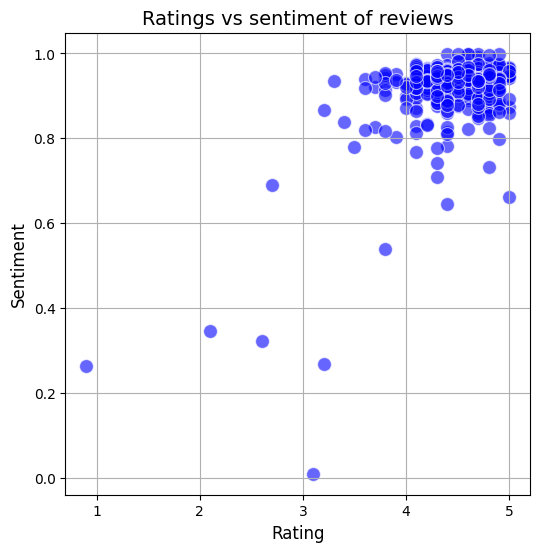

In [ ]:
#To have an idea on the ranges of ratings for imputing

places_df_copy = places_df.copy()

def compare_sentiment_rating(row):
  #if rating and rating count not null, calculate the sentiment of each row
  if pd.notna(row['rating']) and pd.notna(row['user_ratings_total']):
    sent_tot =0
    for review in row['latest_reviews']:
      sentiment_score = analyzer.polarity_scores(review)['compound']
      sent_tot += sentiment_score
    sent_tot = sent_tot/len(row['latest_reviews'])
    return sent_tot, row['rating']
  else:
    return None, None

# Apply function to DataFrame (only if rating or user_ratings_total is empty)
places_df_copy['sentiment_rating'], places_df_copy['rating'] = zip(*places_df_copy.apply(compare_sentiment_rating, axis=1))

#plot rating vs sentiment_rating

# Scatter plot
plt.figure(figsize=(6,6))
sns.scatterplot(x='rating', y='sentiment_rating', data=places_df_copy, s=100, color='b', alpha=0.6)

# Adding labels and title
plt.title('Ratings vs sentiment of reviews', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)

plt.grid(True)
plt.show()

In [ ]:
#print minimum of sentiment_rating
print(places_df_copy['sentiment_rating'].min())

0.009660000000000002


In [ ]:
def analyze_reviews(row):
    # If the rating cell is not empty, skip calculation
    if pd.notna(row['rating']) and pd.notna(row['user_ratings_total']):
        return row['rating'], row['user_ratings_total']

    reviews = row['latest_reviews']
    ratings = []
    for review in reviews:
        sentiment_score = analyzer.polarity_scores(review)['compound']

        # Assign rating based on sentiment score
        if sentiment_score >= 0.7:
            ratings.append(5)
        elif sentiment_score >=0.5:
            ratings.append(4)
        elif sentiment_score >=0:
            ratings.append(3)
        elif sentiment_score >=-0.6:
            ratings.append(2)
        else:
            ratings.append(1)

    # Calculate overall rating and total reviews
    overall_rating = sum(ratings) / len(ratings) if ratings else None
    total_reviews = len(reviews)

    return overall_rating, total_reviews

# Apply function to DataFrame (only if rating or user_ratings_total is empty)
places_df['rating'], places_df['user_ratings_total'] = zip(*places_df.apply(analyze_reviews, axis=1))

# print the null counts of each column
print(places_df.isnull().sum())

name                  0
lat                   0
lng                   0
formatted_address     0
rating                0
user_ratings_total    0
latest_reviews        0
dtype: int64


In [ ]:
#save the updated to a csv
places_df.to_csv('/content/drive/My Drive/codex/places_updated.csv', index=False)

#Data Visualization

In [ ]:
# pip install folium geopy

# import folium
# from folium.plugins import HeatMap

# # Sample data with latitude, longitude, and ratings
# data = pd.DataFrame({
#     'name': ['Location A', 'Location B', 'Location C', 'Location D'],
#     'latitude': [37.7749, 34.0522, 40.7128, 51.5074],  # Example coordinates
#     'longitude': [-122.4194, -118.2437, -74.0060, -0.1278],
#     'rating': [4.5, 4.0, 3.5, 5.0]
# })

# m = folium.Map(location=[7.0, 80.0], zoom_start=8)

# # Prepare data for heatmap (latitude, longitude, weight by rating)
# heat_data = [[row['lat'], row['lng'], row['rating']] for index, row in places_df.iterrows()]

# # Add heatmap to the map
# HeatMap(heat_data).add_to(m)
# # Display map
# m.save("heatmap.html")

# m

In [ ]:
import pandas as pd
import plotly.express as px
color_scale = [(0, 'white'), (1, 'blue')]
# Create an interactive scatter plot
fig = px.scatter(places_df, x='lng', y='lat', color='rating',
                 color_continuous_scale='viridis',
                 size_max=50,  # Adjust the size of the markers
                 hover_name='name',  # Display place names on hover
                 hover_data={'name': True, 'rating': True, 'lng': False, 'lat': False},  # Only show name and rating
                 title='Places in Sri Lanka with Ratings')

# Update layout to fit Sri Lanka's shape
fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title='Places in Sri Lanka with Ratings',
    xaxis=dict(
        range=[79.5, 82],  # Adjust longitude range based on Sri Lanka’s bounding box
        scaleanchor='y',  # Maintain aspect ratio

    ),
    yaxis=dict(
        range=[5.8, 10.5],  # Adjust latitude range based on Sri Lanka’s bounding box
        zeroline=False,
    ),
    width=800,  # Increase plot width
    height=800,  # Increase plot height
)

# Show the plot
fig.show()


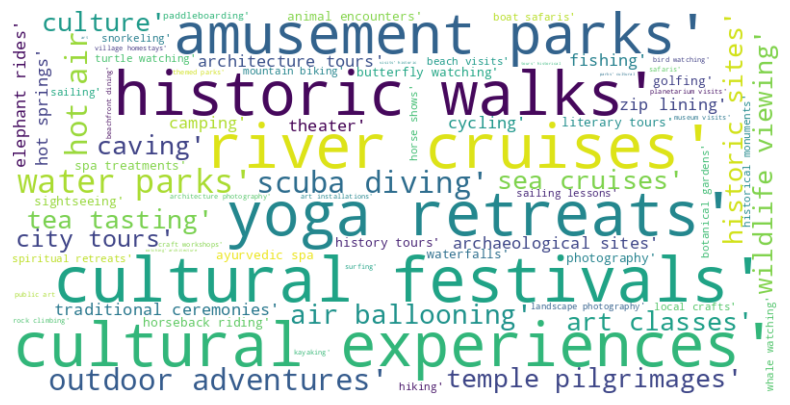

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all preferred activities into a single string
all_activities = ' '.join([' '.join(activities) for activities in users_df['Preferred Activities']])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_activities)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 31.7 MB/s eta 0:00:00


In [ ]:
import dash
from dash import dcc
from dash import html
import pandas as pd
from dash.dependencies import Input, Output

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='place-dropdown',
        options=[{'label': name, 'value': name} for name in places_df['name']],
        value=places_df['name'].iloc[0]  # Default value
    ),
    html.Div(id='place-details')
])

@app.callback(
    Output('place-details', 'children'),
    [Input('place-dropdown', 'value')]
)
def update_place_details(selected_place):
    place = places_df[places_df['name'] == selected_place].iloc[0]
    reviews = place['latest_reviews']
    review_paragraphs = [html.P(review) for review in reviews]

    details = (
        html.Div([
            html.H3(place['name']),
            html.P(f"Address: {place['formatted_address']}"),
            html.P(f"Rating: {place['rating']}"),
            html.H4("Latest Reviews:"),
            *review_paragraphs
        ])
    )
    return details

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>